<a href="https://colab.research.google.com/github/Dishant4277/Drowsiness-Detection-System/blob/main/Drowsiness_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rakibuleceruet_drowsiness_prediction_dataset_path = kagglehub.dataset_download('rakibuleceruet/drowsiness-prediction-dataset')
adinishad_prediction_images_path = kagglehub.dataset_download('adinishad/prediction-images')

print('Data source import complete.')


100%|██████████| 2.17G/2.17G [01:22<00:00, 28.4MB/s]

Extracting files...


100%|██████████| 1.18M/1.18M [00:00<00:00, 2.25MB/s]

Extracting files...
Data source import complete.


# Drowsiness Detection System  

- Drowsy driving is a major hazard, where fatigue and sleepiness compromise a driver's ability to react swiftly and safely.  

- The alarming rise in road accidents caused by drowsy driving highlights the urgent need for preventive measures.  

- Lack of proper sleep is the primary cause, but factors like sleep disorders, medication, alcohol consumption, and late-night shifts also contribute to driver fatigue.  

- Our system actively monitors signs of drowsiness and provides timely alerts, helping prevent accidents and ensuring safer roads.


# Loading data and libraries

In [2]:
!pip install mediapipe
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 51.8 MB/s eta 0:00:00


In [11]:
os.makedirs('./Fatigue Subjects')
os.makedirs('./Active Subjects')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image preprocessing :
### our preprocessing will include
- Detecting faces from images
- Drawing landmarks on our images to increase performance
- Resizing our images
- LabelEncoding
- Image Augmantation

# Landmarks :
We will use mediapipe to draw landmarks on our images after detecting faces and croping them

In [5]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs))

# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))

# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [6]:
IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt

     # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks

    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness,
        circle_radius=ts_circle_radius,
        color=(255, 255, 255)
    )


    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )

    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark

    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.

    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(image_eye_lmks,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

    if cat=='Fatigue Subjects':
        cv2.imwrite(str('./Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('./Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE))
    return resized_array

In [7]:
imgH, imgW, _=0,0,0
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

     # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        # If detections are available.
        if results.multi_face_landmarks:
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [9]:
def face_for_yawn(direc=rakibuleceruet_drowsiness_prediction_dataset_path + '/0 FaceImages', face_cas_path=adinishad_prediction_images_path + '/haarcascade_frontalface_default.xml'):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


In [18]:
dir_path = r'./drive/MyDrive/0 FaceImages/Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
4580


In [19]:
dir_path = r'./drive/MyDrive/0 FaceImages/Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
4592


### Our images will be like this:

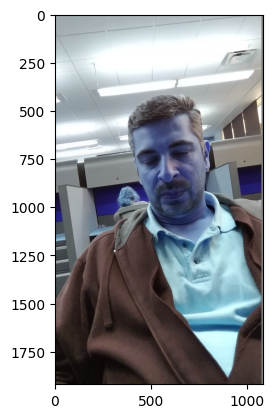

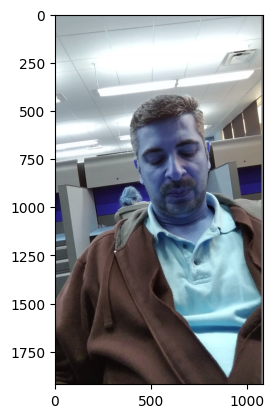

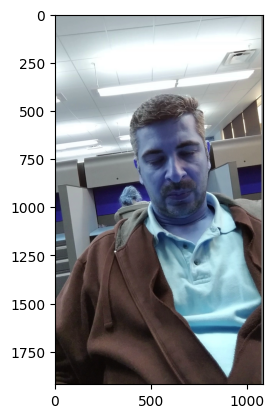

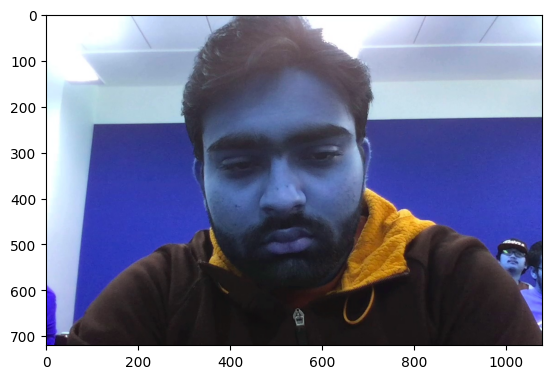

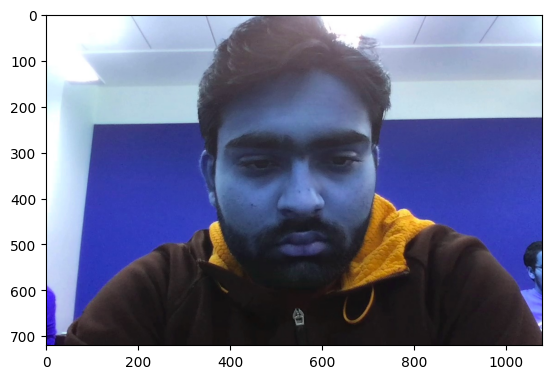

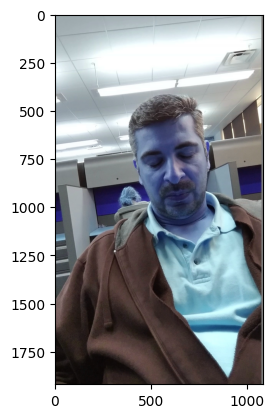

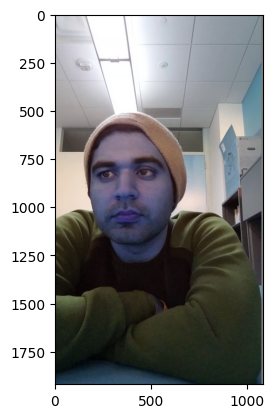

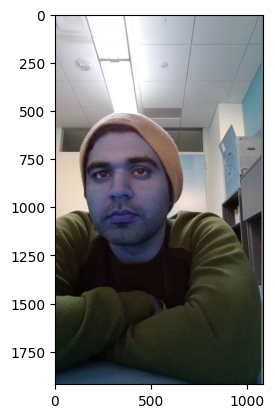

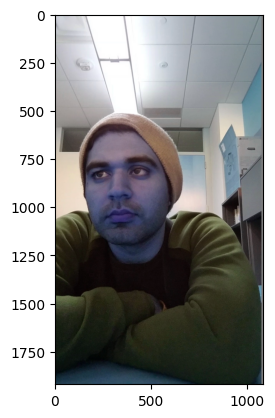

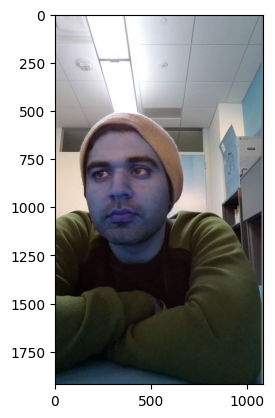

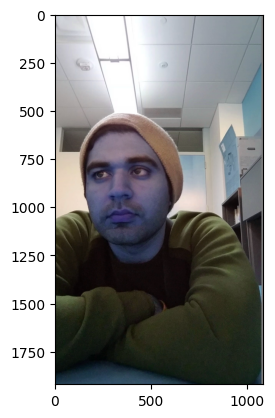

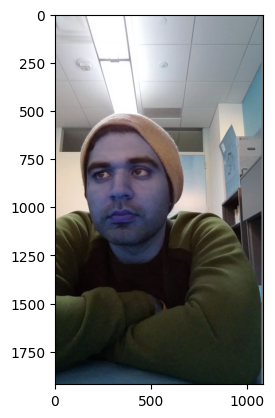

In [23]:
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'./drive/MyDrive/0 FaceImages/{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'./drive/MyDrive/0 FaceImages/{category}/{img}')
      plt.imshow(img_file)
      plt.show()
      plt.close()

### Resizing images

In [24]:
import os
import time
def face_for_yawn(direc="./drive/MyDrive/0 FaceImages/"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


## separate label and features

In [25]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)

## Reshape the array

In [26]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelEncoder

In [27]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

# Splitting

In [28]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [29]:
len(X_test)

1835

In [30]:
len(X_train)

7337

### import some dependencies

In [32]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
# Importing ImageDataGenerator from tensorflow.keras.preprocessing.image instead of keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Data Augmentation

In [33]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [34]:
# Model Elsafty 1
from keras.layers import BatchNormalization
model = tf.keras.models.Sequential()
# Note the input shape is the desired size of the image 145 x 145 with 3 bytes color
# This is the first convolution
model.add(Conv2D(16, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The second convolution
model.add(Conv2D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The third convolution
model.add(Conv2D(64, 10, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The fourth convolution
model.add(Conv2D(128, 12, activation='relu'))
model.add(BatchNormalization())

# Flatten the results to feed into a DNN
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
# Only 1 output neuron.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 143, 143, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 143, 143, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 67, 67, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 67, 67, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 33, 33, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 1, 128)           │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 1, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,423,713 (5.43 MB)

 Trainable params: 1,423,233 (5.43 MB)

 Non-trainable params: 480 (1.88 KB)

In [35]:
history = model.fit(train_generator, epochs=70, validation_data=test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
230/230 ━━━━━━━━━━━━━━━━━━━━ 57s 201ms/step - accuracy: 0.7269 - loss: 0.5102 - val_accuracy: 0.6016 - val_loss: 0.8001
Epoch 2/70
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.7822 - loss: 0.4299 - val_accuracy: 0.5395 - val_loss: 1.3475
Epoch 3/70
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.7963 - loss: 0.4100 - val_accuracy: 0.8000 - val_loss: 0.4201
Epoch 4/70
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.8093 - loss: 0.3973 - val_accuracy: 0.7210 - val_loss: 0.5418
Epoch 5/70
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.8028 - loss: 0.3926 - val_accuracy: 0.8207 - val_loss: 0.3688
Epoch 6/70
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.8183 - loss: 0.3709 - val_accuracy: 0.8300 - val_loss: 0.3532
Epoch 7/70
230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 178ms/step - accuracy: 0.8307 - loss: 0.3527 - val_accuracy: 0.8027 - val_loss: 0.4085
Epoch 8/70
230/230 ━━━━━━━━━━━━━━━━━━━━ 39s 171ms/step - accuracy: 0.8317 - loss: 0

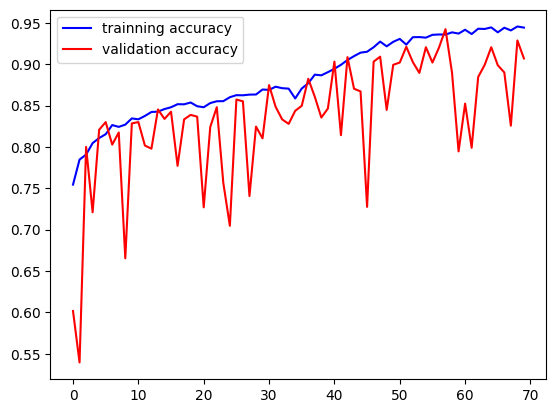

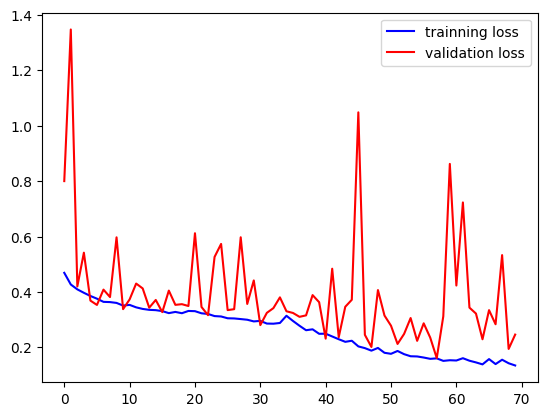

In [36]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [37]:
# You can evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9075 - loss: 0.2617


{'loss': 0.24614271521568298, 'compile_metrics': 0.9068120121955872}

In [38]:
model.save('my_model.h5')
#model = tf.keras.models.load_model('my_model.h5')

In [39]:
# ... (previous code) ...

model.save('my_model.keras')  # Changed from 'my_model.h5' to 'my_model.keras'

#model = tf.keras.models.load_model('my_model.keras') # loading the model would also need to be changed but as it is a comment we will leave it as is.

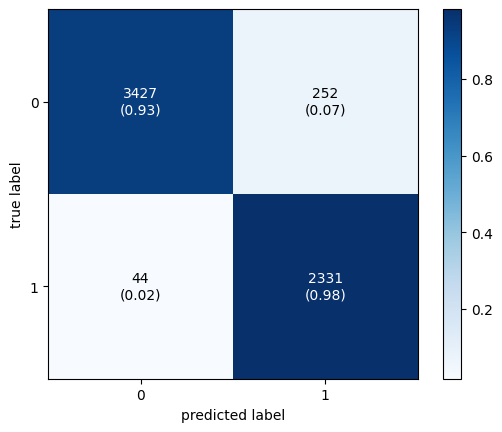

In [40]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
binary1 = np.array([[3427,252],[44,2331]])
fig, ax = plot_confusion_matrix(conf_mat=binary1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# Visualizing our CNN architecture

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 30.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


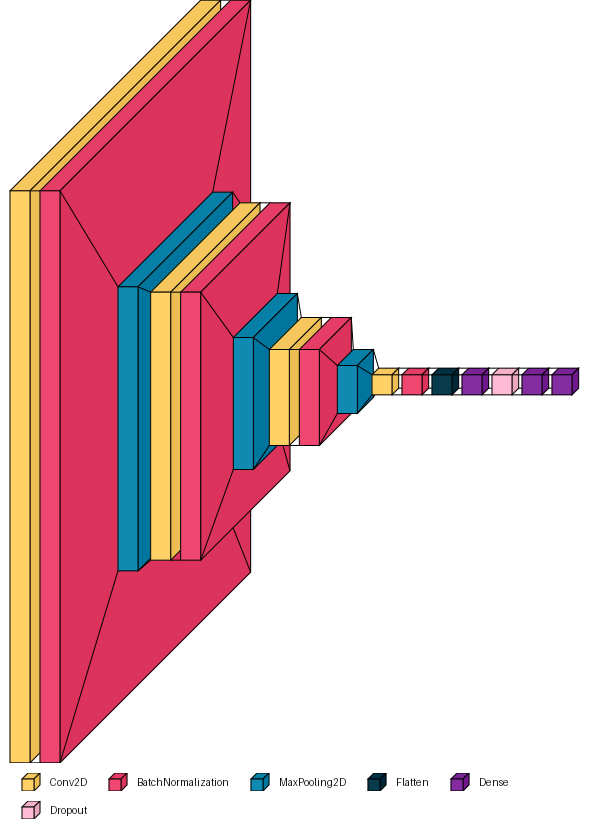

In [42]:
!pip install visualkeras # install visualkeras for alternative visualization
import visualkeras
from tensorflow.keras.utils import plot_model # Changed import statement

# Plot the model using plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

# Alternative visualization using visualkeras
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show
visualkeras.layered_view(model, legend=True) # with legend

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


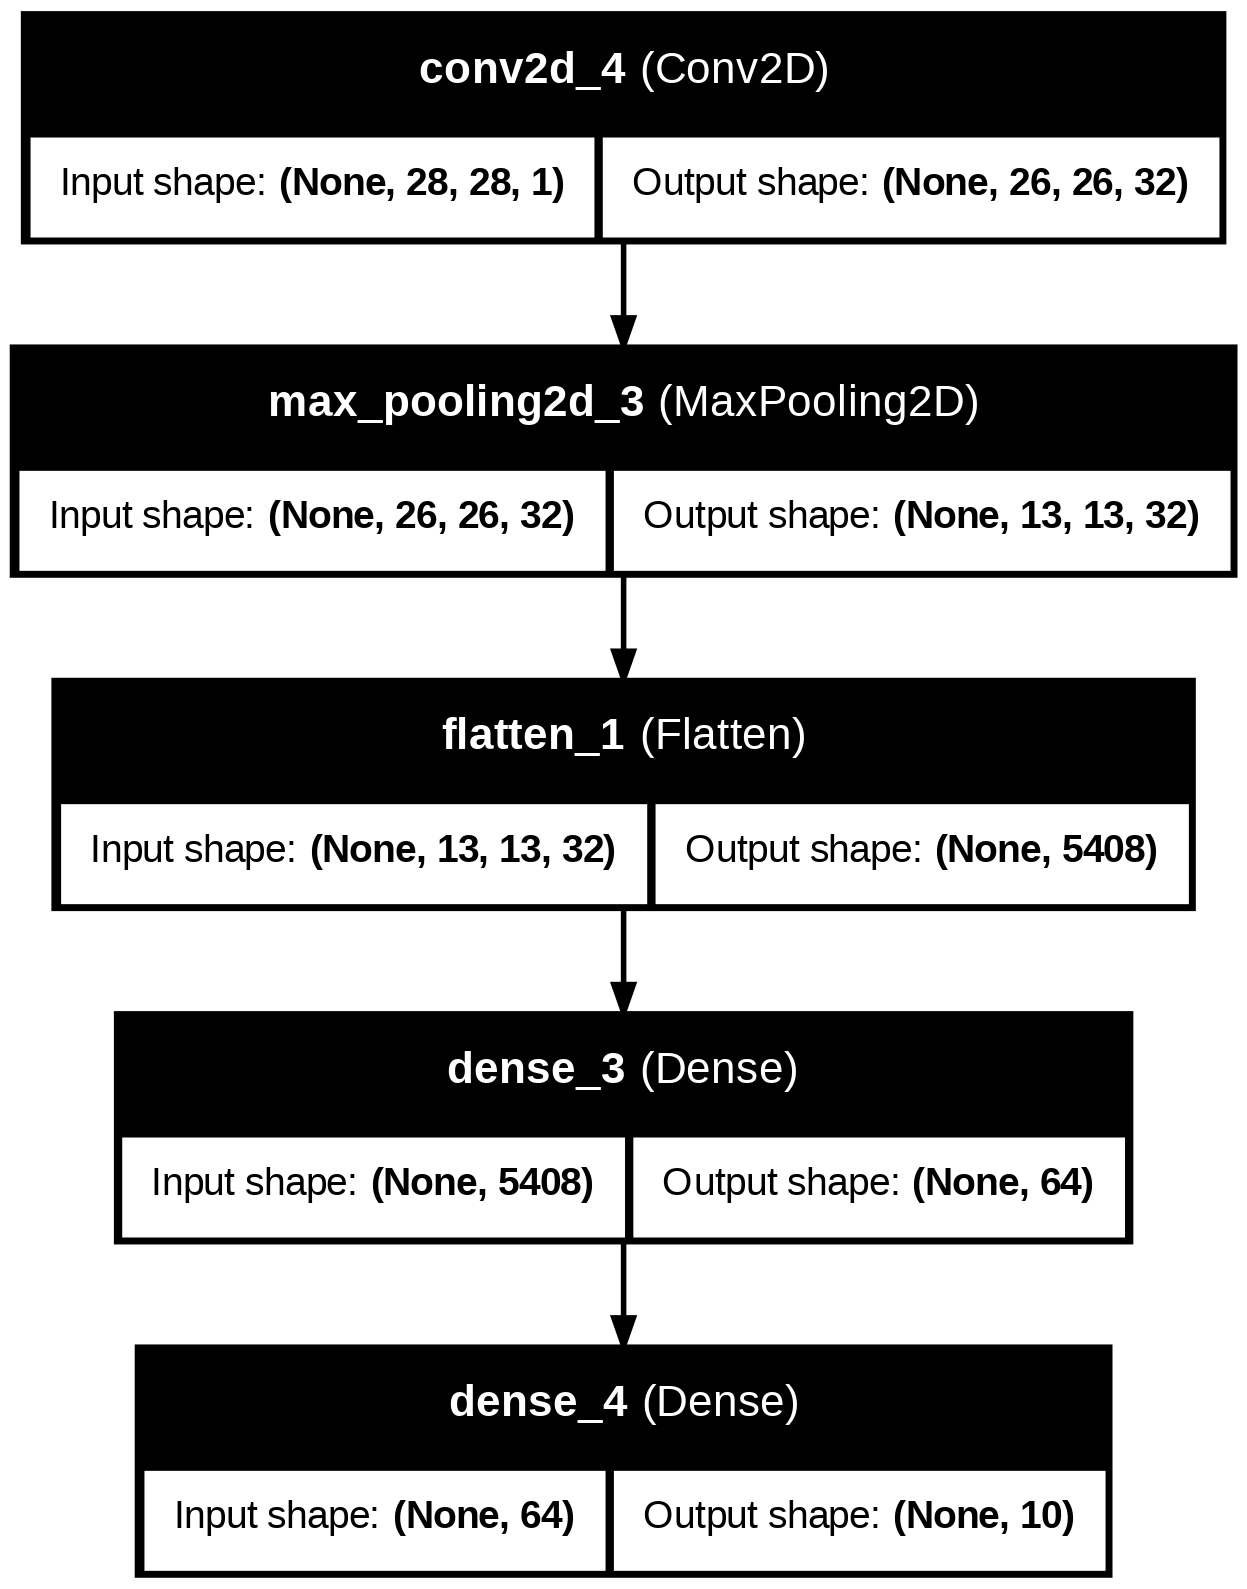

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

# Define a simple model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# Save and visualize model architecture
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
